<a href="https://colab.research.google.com/github/lauragabrysiak/mitx_applied_data_science/blob/main/CAPSTONE_music_recsys_gabrysiak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Music Recommendation System**

**Context:**

With the advent of technology, societies have become more efficient with their lives. At the same time, however, individual human lives have also become more fast-paced and distracted, leaving little time to explore artistic pursuits. Also, technology has made significant advancements in the ability to coexist with art and general entertainment. It has in fact made it easier for humans with a shortage of time to find and consume good content.
Almost every internet-based company's revenue relies on the time consumers spend on its platform. These companies need to be able to figure out what kind of content is needed in order to increase customer time spent and make their experience better. Therefore, one of the key challenges for these companies is figuring out what kind of content their customers are most likely to consume. Spotify is one such audio content provider with a huge market base across the world. With the ever-increasing volume of songs becoming available on the Internet, searching for songs of interest has become a tedious task in itself.
However, Spotify has grown significantly in the market because of its ability to recommend the 'best' next song to each and every customer based on a huge preference database gathered over time - millions of customers and billions of songs. This is done by using smart recommendation systems that can recommend songs based on users' likes/dislikes.

Source: https://olympus.mygreatlearning.com/courses/87799/files/7049375?module_item_id=3469914

**Why is this problem important to solve?**

Competitive advantage by user experience and insights + data as a product.



## **Data Dictionary**

The core data is the Taste Profile Subset released by the Echo Nest as part of the Million Song Dataset. There are two files in this dataset. The first file contains the details about the song id, titles, release, artist name, and the year of release. The second file contains the user id, song id, and the play count of users.

## S1: song_data
*   song_id - A unique id given to every song
*   title - Title of the song
*   Release - Name of the released album
*   Artist_name - Name of the artist
*   year - Year of release

## S2: count_data
*   user _id - A unique id given to the user
*   song_id - A unique id given to the song
*   play_count - Number of times the song was played

## **Data Source**
http://millionsongdataset.com/

## Data Understanding


### **Importing Libraries and the Dataset**

#### Mount Drive

In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


#### Install Libraries

In [118]:
# Installing surprise library
!pip install surprise

In [50]:
# Installing Pandas Profile
!pip install --upgrade matplotlib
!pip install -U ydata-profiling[notebook]==4.0.0 matplotlib==3.5.1  # last matplotlib is 3.8.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 47.7 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
plotnine 0.12.4 requires statsmodels>=0.14.0, but you have statsmodels 0.13.5 which is incompatible.
ydata-profiling 4.0.0 requires matplotlib<3.7,>=3.2, but you have matplotlib 3.8.2 which is incompatible.


  Using cached matplotlib-3.5.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.9 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.2
    Uninstalling matplotlib-3.8.2:
      Successfully uninstalled matplotlib-3.8.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
plotnine 0.12.4 requires matplotlib>=3.6.0, but you have matplotlib 3.5.1 which is incompatible.
plotnine 0.12.4 requires statsmodels>=0.14.0, but you have statsmodels 0.13.5 which is incompatible.


In [ ]:
# Installing Pandas Profile
!pip install spotipy

#### Import Libraries

In [121]:
import warnings                                 # Used to ignore the warning given as output of the code
warnings.filterwarnings('ignore')
from collections import defaultdict             # A dictionary output that does not raise a key error

import numpy as np                              # Basic libraries of python for numeric and dataframe computations
import pandas as pd

import matplotlib.pyplot as plt                 # data visualization
import seaborn as sns                           # data visualization advanced

from sklearn.metrics import mean_squared_error  # A performance metrics in sklearn

from ydata_profiling import ProfileReport       # Adding pandas report
from scipy.stats import pearsonr                # pearson correlation

In [122]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy import SpotifyException

### **Datasets**

#### Import datasets

In [4]:
# Importing the datasets
song_df = pd.read_csv('/content/sample_data/song_data.csv'
                  , on_bad_lines='skip')                        # some of the lines had formatting issues. This can be solved with bad_lines = skip
count_df = pd.read_csv('/content/sample_data/count_data.csv'
                  , on_bad_lines='skip')

In [5]:
rows, columns = song_df.shape
print("Song Dataset: No of rows =", rows, "and No of columns =", columns)

Song Dataset: No of rows = 1000000 and No of columns = 5


In [6]:
rows, columns = count_df.shape
print("Count Dataset: No of rows =", rows, "and No of columns =", columns)

Count Dataset: No of rows = 2000000 and No of columns = 4


In [7]:
print(song_df.info())   # there is some missing information (title (-15) /release (-5) )
print("\n")
print(count_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   song_id      1000000 non-null  object
 1   title        999985 non-null   object
 2   release      999995 non-null   object
 3   artist_name  1000000 non-null  object
 4   year         1000000 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 38.1+ MB
None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   Unnamed: 0  int64 
 1   user_id     object
 2   song_id     object
 3   play_count  int64 
dtypes: int64(2), object(2)
memory usage: 61.0+ MB
None


#### Data Preparation

#### S1) **Count dataset**

Dataset of 2000000 x 3 variables. Includes the number of times that songs were played and by who (user). Includes the song_id as primary key for reference

##### Data Preparation

In [8]:
count_df.columns = ['index','user_id', 'song_id', 'play_count']     # Adding column names
count_df_copy = count_df .copy(deep = True)                         # backup copy
count_df = count_df.drop('index', axis = 1)                         # Dropping index # Drop the column 'Unnamed: 0' // already done

##### Data Univariate EDA

In [9]:
# See top 10 records of count_df data
count_df.head(3)

,user_id,song_id,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1


In [10]:
# See the info of the count_df data
count_df.describe(include='object').transpose

<bound method DataFrame.transpose of                                          user_id             song_id
count                                    2000000             2000000
unique                                     76353               10000
top     6d625c6557df84b60d90426c0116138b617b9449  SOFRQTD12A81C233C0
freq                                         711                8277>

In [30]:
# See the info of the count_df data
count_df.describe(exclude='object').transpose

<bound method DataFrame.transpose of          play_count
count  2.000000e+06
mean   3.045485e+00
std    6.579720e+00
min    1.000000e+00
25%    1.000000e+00
50%    1.000000e+00
75%    3.000000e+00
max    2.213000e+03>

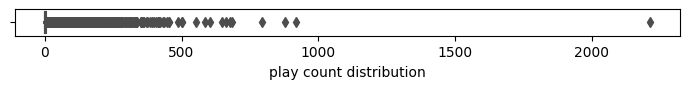

In [23]:
fig = plt.figure(figsize= (7,1))
sns.boxplot(x = count_df["play_count"]
            , color = 'grey').set_xlabel("play count distribution")
fig.tight_layout()

##### Data Multivariate EDA

In [11]:
#### Pandas Report for detailed view original dataset
# Use df_copy
count_profile = ProfileReport(count_df
                        , title="Count Info Report"
                         #, subtitle="Original Dataset"
                         )

In [13]:
#count_profile.to_notebook_iframe()
count_profile.to_file("count_ds_report_001.html")       # for download

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

##### **Observations:**

*   song_id can be used as key for merging (10000 unique - top song SOFRQTD12A81C233C0 with 8277 x)
*   user_id can be used as key for merging (76353 unique - top user ends with b9449 with 711 x)
*   S1 can be used for popularity based recommendation



#### S2) **Song dataset**
Dataset defined by 1000000 x 5 variables. Includes the song information (song_title, song_release, song_artist, song_year) along with song_id which can be used for merging as as a reference

In [14]:
print(song_df.shape, "\n", song_df.head(3))

(1000000, 5) 
               song_id              title                release  \
0  SOQMMHC12AB0180CB8       Silent Night  Monster Ballads X-Mas   
1  SOVFVAK12A8C1350D9        Tanssi vaan            Karkuteillä   
2  SOGTUKN12AB017F4F1  No One Could Ever                 Butter   

        artist_name  year  
0  Faster Pussy cat  2003  
1  Karkkiautomaatti  1995  
2    Hudson Mohawke  2006  


In [33]:
temp = song_df

temp = temp.dropna(axis=0)                            # drop na's
#temp = temp.drop_duplicates()                        # drop duplicate rows  | To do after merge
#temp = temp[temp['year'] != 0]                       # dropping all year info  == 0 | To do after merge

temp.columns = ['song_id','song_title', 'song_release', 'song_artist', 'song_year'] # Adding column names

print(temp.shape, "\n\n", temp.sample(3))
song_df = temp

(999980, 5) 

                    song_id                        song_title  \
839137  SOPMKMZ12A6D4F813D       Come And Get These Memories   
101133  SOLBWQX12AB0185270  Romantic Warrior (Album Version)   
685790  SOEMWFS12AB0183224                         La vérité   

                     song_release                    song_artist  song_year  
839137  The Definitive Collection  Martha Reeves & The Vandellas          0  
101133                    Returns              Return To Forever          0  
685790          Le mal de la nuit           Tout Simplement Noir       1997  


In [34]:
# See the info of the count_df data
song_df.describe(include='object').transpose

<bound method DataFrame.transpose of                    song_id song_title   song_release      song_artist
count               999980     999980         999980           999980
unique              999036     702424         149287            72664
top     SOFQIZF12A67ADE730      Intro  Greatest Hits  Michael Jackson
freq                     3       1510           2014              194>

In [35]:
# See the info of the count_df data
song_df.describe(exclude='object').transpose

<bound method DataFrame.transpose of            song_year
count  999980.000000
mean     1030.346259
std       998.744361
min         0.000000
25%         0.000000
50%      1969.000000
75%      2002.000000
max      2011.000000>

In [21]:
#### Pandas Report for detailed view original dataset
# Use df_copy
song_profile = ProfileReport(song_df
                             , title="Song Info Report"
                             #, subtitle="Original Dataset"
                             )

In [ ]:
song_profile.to_notebook_iframe()
#song_profile.to_file("song_ds_report_001.html")       # for download

Observations:

*   song_id: 999056 unique and top 1 x 3
*   title: 702428 unique and top 1 = 'Intro'  (most Albums include an Intro 'song')
*   release: 149288 unique and top 1 = 'Greatest Hits'
*   artist_name: 72665 and top 1 = 'Michael Jackson'



#### Using the Spotify Web API for data augmentation

In [24]:
temp['song_id'][1]        # example of song_id (to be used for spotipy)

'SOVFVAK12A8C1350D9'

In [25]:
temp['song_title'][1]        # example of song_id (to be used for spotipy)

'Tanssi vaan'

[Spotify Web Developer instructions](https://developer.spotify.com/documentation/web-api/concepts/spotify-uris-ids)

[Spotify Web API instructions](https://developer.spotify.com/documentation/web-api/reference/get-an-artist)

[Using Spotify Web App](https://garrecht-metzger.medium.com/getting-started-with-the-spotify-api-using-spotipy-bfb2340293c9)




In [ ]:
# Replace 'YOUR_CLIENT_ID', 'YOUR_CLIENT_SECRET', and 'YOUR_REDIRECT_URI' with your actual credentials
client_id = '930c85172af549c7bed7661f025edf11'
client_secret = 'b33c88126c014981b3fc1d7c426d3a1c'
redirect_uri = 'http://localhost:8888/callback'

# Set up Spotify API credentials
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id, client_secret=client_secret))

# Example: Augmenting a dataset using song IDs
song_ids = temp['song_id']                   #--> Spotify IDs seem not to be valid

# Initialize a list to store augmented data
augmented_data = []

# Retrieve information for each song ID
for song_id in song_ids:
    try:
        track_info = sp.track(song_id)
        artist_info = sp.artist(track_info['artists'][0]['id'])

        # Extract relevant information
        track_name = track_info['name']
        artist_name = artist_info['name']
        release_date = track_info['album']['release_date']
        popularity = track_info['popularity']
        artist_genres = artist_info['genres']

        # Add the augmented data to the list
        augmented_data.append({
            'song_id': song_id,
            'track_name': track_name,
            'artist_name': artist_name,
            'release_date': release_date,
            'popularity': popularity,
            'genres': artist_genres
        })
    #except SpotifyException as e:
        #print(f"Error for song ID {song_id}: {e}")

# Convert the augmented data to a DataFrame
augmented_df = pd.DataFrame(augmented_data)

# Display the augmented DataFrame
print("Augmented DataFrame:")
print(augmented_df)

Spotify IDs seem not to be valid

##### Text normalization

In [ ]:
## Normalize Text variables

import re
# from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer

# Function to perform text normalization
def normalize_text(text):

    text = text.lower()                                                           # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)                                           # Remove punctuation
    # stop_words = set(stopwords.words('english'))                                # Remove stop words (using NLTK library)
    # text = ' '.join([word for word in text.split() if word not in stop_words])
    # stemmer = PorterStemmer()                                                   # Stemming (using Porter Stemmer from NLTK)
    # text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

In [ ]:
# Apply the normalization function to the 'TextColumn'
temp['song_title'] = temp['song_title'].apply(normalize_text)
temp['song_release'] = temp['song_release'].apply(normalize_text)
temp['song_artist'] = temp['song_artist'].apply(normalize_text)

In [ ]:
song_df = temp
#temp = []

##### Pandas Report Songs Dataset

In [ ]:
#### Pandas Report original dataset
# Use df_copy
#profile_song = ProfileReport(song_df
#                        , title="Song Info Report"
#                        #, subtitle="Original Dataset"
#                        )

In [ ]:
#profile_song.to_notebook_iframe()

#### **Final Observations and Insights:**

*   Song data:
    *  data structure: Prunned data frame has 5 variables (4 cat and 1 num) x 999980 observations. All other observations (20) were dropped as they had na's.
    *  There are 505 rows (0.1%)  that are duplicated that will  be dropped
    *  48.4% of year var has values = 0 values. The ranges of year goes from 1922 - 2011 --> FIXED


*   Count data:
    *  Dataset has no missing data or dupliate rows
    *  Mean value of song_count is 3.0454845 whit t=values ranging from 1 - 2000
    *  56.9% of songs are played 1 x. Clear presence of outliers


#### Create subset for rapid testing (0.1%)

In [ ]:
# Create sample subsets to go through project quickly

# count_df = count_df .sample(frac=0.01, random_state=42)
# song_df = song_df.sample(frac=0.01, random_state=42)

In [60]:
print(count_df.shape, "\n\n", song_df.shape)

(2000000, 3) 

 (999980, 5)


### **Final Dataset**

In [278]:
# Left merge the count_df and song_df data on "song_id". Drop duplicates from song_df data simultaneously
## Name the obtained dataframe as "df"

temp = pd.merge(  count_df # 2000000 x 3
                , song_df # 999980 x 5
                , on='song_id'
                , how='left'
                )

# df= temp.drop_duplicates(subset='song_id')

In [279]:
temp.shape

(2086946, 7)

In [280]:
temp.sample(3)

,user_id,song_id,play_count,song_title,song_release,song_artist,song_year
1297119,e64cf25bf64967a5735040dc3bf34866bb6aabf9,SOHYSXA12AB0186704,1,Mockingbird,R&B 2006,Eminem,2004
930260,c9333477733adfc46ec1e40a4d27ff4efcf782af,SOBKRVG12A8C133269,1,I Stand Corrected (Album),Vampire Weekend,Vampire Weekend,2007
1656542,838b5da63a30480b9cb2518611b8e5a1030417a1,SOMMLDP12A8C13BA46,1,Not the One (Album Version),Smash,The Offspring,1994


In [267]:
# checking for no NA's or NULLs
print(temp.isna().sum(),"\n")
print(temp.isnull().sum(),"\n")

user_id         0
song_id         0
play_count      0
song_title      0
song_release    0
song_artist     0
song_year       0
dtype: int64 

user_id         0
song_id         0
play_count      0
song_title      0
song_release    0
song_artist     0
song_year       0
dtype: int64 



In [281]:
# Cleanup of dataset

temp = temp.drop_duplicates()                        # drop duplicate rows  | To do after merge
# temp = temp[temp['song_year'] != 0]                  # dropping all year info  == 0 | Not do

# PS: year info  == 0 will be kep as the song information does not influence the rating information ir decision

In [282]:
df_final = temp     # temp copy for processing

In [283]:
df_final.shape

(2054534, 7)

**Think About It:** As the user_id and song_id are encrypted. Can they be encoded to numeric features?

## Dataset prunning

In [284]:
# Apply label encoding for "user_id" and "song_id"
from sklearn.preprocessing import LabelEncoder

# testing purposes
temp = df_final.copy()  # Make a copy to avoid modifying the original DataFrame
user_encoder = LabelEncoder()

# final df
df_final['user_id'] = user_encoder.fit_transform(df_final['user_id'])
df_final['song_id'] = user_encoder.fit_transform(df_final['song_id'])

In [287]:
# looking for user 6958
df_final[df_final['user_id'] == 6958]

# how many playcounts has 6958
df_final[df_final['user_id'] == 6958].describe(exclude = 'object')

,user_id,song_id,play_count,song_year
count,103.0,103.000000,103.000000,103.00000
mean,6958.0,4270.718447,1.378641,1712.07767
std,0.0,2824.478308,1.085705,710.32871
min,6958.0,12.000000,1.000000,0.00000
25%,6958.0,2116.500000,1.000000,2000.00000
50%,6958.0,3718.000000,1.000000,2005.00000
75%,6958.0,6314.000000,1.000000,2007.50000
max,6958.0,9891.000000,5.000000,2009.00000


**Think About It:** As the data also contains users who have listened to very few songs and vice versa, is it required to filter the data so that it contains users who have listened to a good count of songs and vice versa?

A dataset of size 2000000 rows x 7 columns can be quite large and may require a lot of computing resources to process. This can lead to long processing times and can make it difficult to train and evaluate your model efficiently.
In order to address this issue, it may be necessary to trim down your dataset to a more manageable size.

In [273]:
print(df_final.info())
print("\n")

# check play_count
print(df_final.describe(exclude='object').transpose())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2054534 entries, 0 to 2086945
Data columns (total 7 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   user_id       int64 
 1   song_id       int64 
 2   play_count    int64 
 3   song_title    object
 4   song_release  object
 5   song_artist   object
 6   song_year     int64 
dtypes: int64(4), object(3)
memory usage: 125.4+ MB
None


                count          mean           std  min      25%      50%  \
user_id     2054534.0  38134.661889  22044.764724  0.0  19109.0  37947.0   
song_id     2054534.0   4976.886980   2888.537703  0.0   2434.0   5031.0   
play_count  2054534.0      3.038972      6.576965  1.0      1.0      1.0   
song_year   2054534.0   1633.598626    774.758474  0.0   1984.0   2002.0   

                75%      max  
user_id     57136.0  76352.0  
song_id      7522.0   9999.0  
play_count      3.0   2213.0  
song_year    2007.0   2010.0  


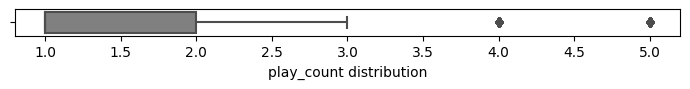

In [230]:
fig = plt.figure(figsize= (7,1))
sns.boxplot(x = df_final["play_count"]
            , color = 'grey').set_xlabel("play_count distribution")
fig.tight_layout()

Consideration: How would the distribution of teh data look like if we would exclude any outliers following a IQR analysis

In [70]:
# Prunning outliers (top bottom 1%) by Calculating the IQR (Interquartile Range)
temp = df_final
f1p = temp['play_count'].quantile(0.01)
l1p = temp['play_count'].quantile(0.99)
IQR = l1p - f1p

# Define a threshold for identifying outliers
outlier_threshold = 1.5

# Remove outliers
df_no_outliers = temp[(temp['play_count'] >= f1p - outlier_threshold * IQR) & (temp['play_count'] <= l1p + outlier_threshold * IQR)]

In [71]:
print(" distribution of version of dataset with no outliers: \n\n", df_no_outliers.describe(exclude='object').transpose())   # any songs with more than 63 plays should be dropped

 distribution of version of dataset with no outliers: 

                 count         mean         std  min     25%     50%     75%  \
play_count  2084144.0     2.894696    4.600872  1.0     1.0     1.0     3.0   
song_year   2084144.0  1636.631780  772.313821  0.0  1985.0  2003.0  2007.0   

               max  
play_count    63.0  
song_year   2010.0  


##### Dataset Pruning by Selection Criteria: Ratings CUTOFF

*PS: pruning done on original df_final*

In [286]:
# Get the column containing the users
users = df_final.user_id
# Create a dictionary from users to their number of songs
ratings_count = dict()
for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [288]:
RATINGS_CUTOFF = 103 #90       ### Adapting to be 103 so that user 6958 can be included
remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)
df = df_final.loc[~df_final.user_id.isin(remove_users)]

In [289]:
df.shape

(382682, 7)

In [290]:
# looking for user 6958
df[df['user_id'] == 6958]

,user_id,song_id,play_count,song_title,song_release,song_artist,song_year
205,6958,12,1,Aunt Eggma Blowtorch,Everything Is,Neutral Milk Hotel,1995
206,6958,40,1,Full Circle,Breakout,Miley Cyrus,2008
207,6958,151,2,Poor Jackie,Rabbit Habits,Man Man,2008
208,6958,326,1,Hot N Cold (Manhattan Clique Remix Radio Edit),Hot N Cold,Katy Perry,2008
209,6958,447,1,Daisy And Prudence,Distillation,Erin McKeown,2000
...,...,...,...,...,...,...,...
303,6958,9398,1,The World's Greatest,The R. In R&B Greatest Hits Collection Vol. 1,R. Kelly,2001
304,6958,9451,1,Kabul Shit,The Fear,Lily Allen,2009
305,6958,9510,1,Daniel Cowman,Mary Ann meets the Gravediggers and other shor...,Regina Spektor,2002
306,6958,9780,1,Snake,Sings The Greys,Frightened Rabbit,0


##### Dataset Pruning by Selection Criteria: User CUTOFF

In [291]:
# Get the column containing the songs
songs = df.song_id
# Create a dictionary from songs to their number of users
ratings_count = dict()
for song in songs:
    # If we already have the song, just add 1 to their rating count
    if song in ratings_count:
        ratings_count[song] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[song] = 1

In [292]:
# We want our song to be listened by at least 120 users to be considered (why?)
RATINGS_CUTOFF = 120
remove_songs = []
for song, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_songs.append(song)
df_final= df.loc[~df.song_id.isin(remove_songs)]

In [293]:
df_final.shape

(108479, 7)

In [298]:
# looking for user 6958
df_final[df_final['user_id'] == 6958].head()

,user_id,song_id,play_count,song_title,song_release,song_artist,song_year
209,6958,447,1,Daisy And Prudence,Distillation,Erin McKeown,2000
211,6958,512,1,The Ballad of Michael Valentine,Sawdust,The Killers,2004
212,6958,549,1,I Stand Corrected (Album),Vampire Weekend,Vampire Weekend,2007
213,6958,703,1,They Might Follow You,Tiny Vipers,Tiny Vipers,2007
214,6958,719,1,Monkey Man,You Know I'm No Good,Amy Winehouse,2007


##### Dataset Pruning by Selection Criteria: Play_Count CUTOFF

In [299]:
# Drop records with play_count more than(>) 5
df_final=df_final[df_final.play_count <= 5]

In [300]:
# Check the shape of the data
df_final.shape

(98011, 7)

In [301]:
# looking for user 6958
df_final[df_final['user_id'] == 6958].head()

,user_id,song_id,play_count,song_title,song_release,song_artist,song_year
209,6958,447,1,Daisy And Prudence,Distillation,Erin McKeown,2000
211,6958,512,1,The Ballad of Michael Valentine,Sawdust,The Killers,2004
212,6958,549,1,I Stand Corrected (Album),Vampire Weekend,Vampire Weekend,2007
213,6958,703,1,They Might Follow You,Tiny Vipers,Tiny Vipers,2007
214,6958,719,1,Monkey Man,You Know I'm No Good,Amy Winehouse,2007


A total of 138285 x 7 remains after applying pruning selection criteria.

In [91]:
#### Pandas Report original dataset
# Use df_copy
profile_final = ProfileReport(df_final
                        , title="Final dataset Report"
                        #, subtitle="Original Dataset"
                        )

In [92]:
profile_final.to_notebook_iframe()
profile_final.to_file("final_df_report_001.html")       # for download

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Final Dataset (df_final)

| Dataset statistics            |         |
| ----------------------------- | ------- |
| Number of variables           | 7       |
| Number of observations        | 154377  |
| Missing cells                 | 0       |
| Missing cells (%)             | 0.00%   |
| Duplicate rows                | 5876       |
| Duplicate rows (%)            | 3.8%   |
| Total size in memory          | 9.4 MiB |
| Average record size in memory | 64.0 B  |

Alerts:

      *  song_year has 23399 (16.9%) zeros ---> Intentionally kept


In [302]:
## After realizing that there are duplicate rows:
temp = df_final.drop_duplicates()

print(df_final.shape)
print(temp.shape)

df_final = temp

(98011, 7)
(98011, 7)


##### Download backup copy of final_dataset

In [303]:
df_final.to_csv('df_final.csv', index=False)

## **Exploratory Data Analysis**

### **Numerical Variables EDA**

In [304]:
# numerical variables
print(df_final.describe(exclude='object').transpose())

              count          mean           std   min      25%      50%  \
user_id     98011.0  37826.195794  22003.413849  17.0  19193.0  36948.0   
song_id     98011.0   4924.038934   2919.041663  21.0   2220.0   4973.0   
play_count  98011.0      1.716552      1.089676   1.0      1.0      1.0   
song_year   98011.0   1658.116324    757.246619   0.0   1995.0   2005.0   

                75%      max  
user_id     56868.0  76342.0  
song_id      7628.0   9981.0  
play_count      2.0      5.0  
song_year    2008.0   2010.0  


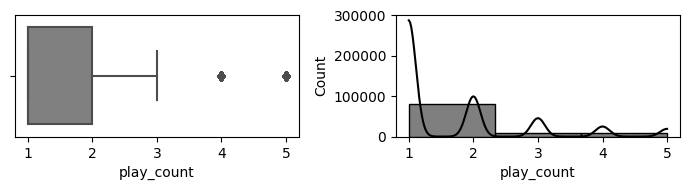

In [305]:
# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 2))
# p1: top users by ratings
#sns.barplot(x='song_id', y='play_count', data=df_final, color='black', ax=axes[0])
sns.boxplot(x = df_final["play_count"], color = 'grey', ax=axes[0])
# p2: ratings distribution (min = 5 given selection criteria)
sns.histplot(df_final['play_count'], bins=3, kde=True, color='black', ax=axes[1])
fig.tight_layout()

### **Categorical Variables EDA**

In [306]:
# categorical variables
print(df_final.describe(include='object').transpose())

              count unique                               top  freq
song_title    98011    464                      Use Somebody  1304
song_release  98011    362  Ray Guns Are Not Just The Future  1593
song_artist   98011    209                          Coldplay  5027


In [307]:
# Multivariate categorical analysis: Stats by YEAR
year_view = df_final.groupby(['song_year'])['play_count'].agg(['mean', 'count', 'max']).sort_values(by='count', ascending=False).reset_index()
year_view.head()

# year-wise songs listened: done
# song that has been played most

,song_year,mean,count,max
0,0,1.837226,16913,5
1,2009,1.720260,14635,5
2,2008,1.698893,11926,5
3,2007,1.612840,9642,5
4,2003,1.605795,6626,5


In [308]:
# Multivariate categorical analysis: Top songs with year information
df_final.groupby(['song_id','song_title','song_year'])['play_count'].agg(['mean', 'count', 'max']).sort_values(by='count', ascending=False).reset_index().head(10)

,song_id,song_title,song_year,mean,count,max
0,8582,Use Somebody,2008,1.964724,1304,5
1,6293,Yellow,2000,1.742188,1024,5
2,4270,Don't Stop The Music,2007,1.598592,852,5
3,7796,Love Story,2008,1.829843,764,5
4,1286,Somebody To Love,2010,1.893048,748,5
5,352,Dog Days Are Over (Radio Edit),0,2.211290,620,5
6,1118,Clocks,2002,1.807958,578,5
7,2220,Sehr kosmisch,0,2.263525,573,5
8,4152,The Scientist,2002,1.940455,571,5
9,9249,Everlong,1992,1.673993,546,5


Songs played in a year

In [309]:
# Find out the number of songs played in a year
  # Hint: Use groupby function on the 'year' column
top_songs_year = df_final.groupby(['song_year'])['play_count'].agg(['mean', 'count','max']).sort_values(['song_year'],ascending=False).reset_index()
round(top_songs_year).head()

,song_year,mean,count,max
0,2010,2.0,4000,5
1,2009,2.0,14635,5
2,2008,2.0,11926,5
3,2007,2.0,9642,5
4,2006,2.0,6358,5


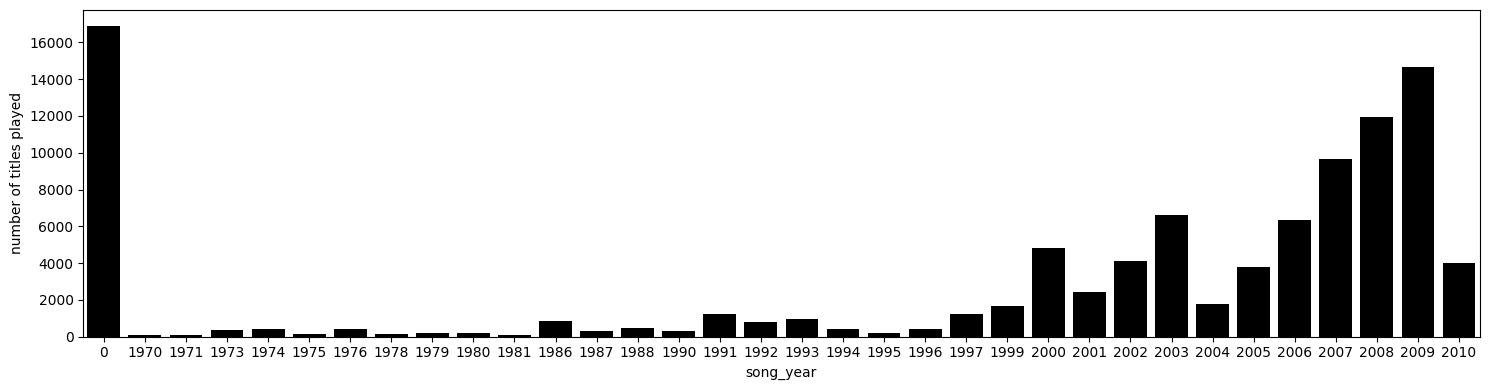

In [310]:
# Create a barplot plot with y label as "number of titles played" and x -axis year

# Set the figure size
fig = plt.figure(figsize= (15,4))
sns.barplot(x='song_year', y='count', data=top_songs_year, color='black')
# Set the x label of the plot
plt.xlabel("song_year")
# Set the y label of the plot
plt.ylabel('number of titles played')
# Show the plot
fig.tight_layout()

#### **Observations and Insights:**

Unique ocurrences:

                  *   There are 2187 unique users
                  *   There are 343 unique songs_ids
                  *   There are 346 unique song_titles
                  *   There are 275 unique song_releases
                  *   There are 152 unique song_artists

Top ocurrences:

*    Top songs

          *   Top songs_id is SOWCKVR12A8C142411 with 1538 freq
          *   Top song_title is use somebody with 1538 - most probably with SOWCKVR12A8C142411 song_id

| rank | song_title          | freq | freq_% |
| ---- | ------------------- | ---- | ------ |
| 1    | use somebody        | 1602 | 1.20%  |
| 2    | yellow              | 1264 | 0.90%  |
| 3    | dont stop the music | 960  | 0.70%  |
| 4    | somebody to love    | 920  | 0.70%  |
| 5    | love story          | 910  | 0.70%  |

*    Top releases

          *   Top song_release is my worlds with 1913 freq

| rank | song_release                     | freq | freq_% |
| ---- | -------------------------------- | ---- | ------ |
| 1    | my worlds                        | 1967 | 1.40%  |
| 2    | ray guns are not just the future | 1855 | 1.30%  |
| 3    | vampire weekend                  | 1754 | 1.30%  |
| 4    | hell train                       | 1708 | 1.20%  |
| 5    | give up                          | 1632 | 1.20%  |

*    Top song_artists
          *   Top song_artists is coldplay with 6313 freq

| rank | song_artist          | freq | freq_% |
| ---- | -------------------- | ---- | ------ |
| 1    | coldplay             | 6527 | 4.70%  |
| 2    | kings of leon        | 4441 | 3.20%  |
| 3    | the killers          | 4254 | 3.10%  |
| 4    | florence the machine | 3046 | 2.20%  |
| 5    | justin bieber        | 2858 | 2.10%  |

*   Top users

        *   Top user is ce5c912bb8044f23fc0fc31bd986b8d0a7303db5 with 278 freq




Now that we have explored the data, let's apply different algorithms to build recommendation systems.

**Note:** Use the shorter version of the data, i.e., the data after the cutoffs as used in Milestone 1.

## Building various models

### **M1) Popularity-Based Recommendation Systems**

Let's take the count and sum of play counts of the songs and build the popularity recommendation systems based on the sum of play counts.

In [311]:
# Calculating average play_count
       # Hint: Use groupby function on the song_id column
avg_counts= df_final.groupby('song_id')['play_count'].mean().reset_index()

# Calculating the frequency a song is played
      # Hint: Use groupby function on the song_id column
count_counts = df_final.groupby('song_id')['play_count'].count().reset_index()

In [312]:
# Making a dataframe with the average_count and play_freq
avg_play_counts = df_final.groupby(['song_id','song_title'])['play_count'].agg(['mean', 'count']).sort_values(by='count', ascending=False).reset_index()

# Let us see the first five records of the final_play dataset
avg_play_counts.head()

,song_id,song_title,mean,count
0,8582,Use Somebody,1.964724,1304
1,6293,Yellow,1.742188,1024
2,4270,Don't Stop The Music,1.598592,852
3,7796,Love Story,1.829843,764
4,1286,Somebody To Love,1.893048,748


Now, let's create a function to find the top n songs for a recommendation based on the average play count of song. We can also add a threshold for a minimum number of playcounts for a song to be considered for recommendation.

In [313]:
# Build the function to find top n songs

# p1: avg_play_counts: dataframe to sort
# p2: n: n products
# p3: min_playcounts: def what a min interaction is (min())

def top_n_songs(df, n, min_playcount_def):

    # Finding songs with minimum number of playcounts
    #min_playcount_def = df['count'].min()                                     # def a min playcount
    min_recommendations = df[df['count'] >=  min_playcount_def]               # recommendations that comprise def of min playcounts had to be fixed to be >= as they are min requirements

    # Sorting values with respect to average rating
    sorted_recommendations = min_recommendations.sort_values(['count'], ascending = False)#.reset_index()

    return sorted_recommendations[:n]

In [314]:
# Testing function
result = top_n_songs(avg_play_counts, 3, 5)
test = avg_play_counts[avg_play_counts['count'] >=  5].sort_values(['count'], ascending = False)

print(
      avg_play_counts.head(3)
      , "\n\n"
      , result # getting the index
      , "\n\n"
      , test[:3]
      )

   song_id            song_title      mean  count
0     8582          Use Somebody  1.964724   1304
1     6293                Yellow  1.742188   1024
2     4270  Don't Stop The Music  1.598592    852 

    song_id            song_title      mean  count
0     8582          Use Somebody  1.964724   1304
1     6293                Yellow  1.742188   1024
2     4270  Don't Stop The Music  1.598592    852 

    song_id            song_title      mean  count
0     8582          Use Somebody  1.964724   1304
1     6293                Yellow  1.742188   1024
2     4270  Don't Stop The Music  1.598592    852


In [315]:
# Recommend top 10 songs using the function defined above
top_n_songs(avg_play_counts, 10, 5)

,song_id,song_title,mean,count
0,8582,Use Somebody,1.964724,1304
1,6293,Yellow,1.742188,1024
2,4270,Don't Stop The Music,1.598592,852
3,7796,Love Story,1.829843,764
4,1286,Somebody To Love,1.893048,748
5,7998,Nothin' On You [feat. Bruno Mars] (Album Version),1.979104,670
6,352,Dog Days Are Over (Radio Edit),2.211290,620
7,1118,Clocks,1.807958,578
8,2220,Sehr kosmisch,2.263525,573
9,4152,The Scientist,1.940455,571


### **User User Similarity-Based Collaborative Filtering**

In this type of recommendation system, we do not need any information about the users or items. We only need user item interaction data to build a collaborative recommendation system. For example playcounts.

### Some useful functions

Below is the function to calculate precision@k and recall@k, RMSE, and F1_Score@k to evaluate the model performance.

**Think About It:** Which metric should be used for this problem to compare different models?

In [317]:
# The function to calulate the RMSE, precision@k, recall@k, and F_1 score
def precision_recall_at_k(model, k = 30, threshold = 1.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions=model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x : x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[ : k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[ : k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    # Command to print the overall precision
    print('Precision: ', precision)

    # Command to print the overall recall
    print('Recall: ', recall)

    # Formula to compute the F-1 score
    print('F_1 score: ', round((2 * precision * recall) / (precision + recall), 3))

**Think About It:** In the function precision_recall_at_k above the threshold value used is 1.5. How precision and recall are affected by changing the threshold? What is the intuition behind using the threshold value of 1.5?

### Useful function from surprise library

In [318]:
# To compute the accuracy of models
from surprise import accuracy
# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader
# Class for loading datasets
from surprise.dataset import Dataset
# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV
# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split
# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic
# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD
# for implementing K-Fold cross-validation
from surprise.model_selection import KFold
# For implementing clustering-based recommendation system
from surprise import CoClustering

In [319]:
# Instantiating Reader scale with expected rating scale
 #use rating scale (0, 5)
reader = Reader(rating_scale = (0, 5)) # min = 0 and max = 5 x played by user

# Loading the dataset
 # Take only "user_id","song_id", and "play_count"
data = Dataset.load_from_df(df_final[['user_id', 'song_id', 'play_count']], reader)      # can be solved with S1 count_df

# Splitting the data into train and test dataset
 # Take test_size = 0.4, random_state = 42
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

In [320]:
# test splitting:
print(reader, "\n"
      , data, "\n"
      , trainset, "\n"
      , testset[:2]
      )

 [(74031, 2115, 2.0), (20844, 8949, 1.0)]


**Think About It:** How changing the test size would change the results and outputs?

### M2) Defining User - User Similarity Model

1.   Initialize the KNNBasic model using sim_options provided, Verbose=False,
and setting random_state=1

1. Fit the model on the training data

1. Use the precision_recall_at_k function to calculate the metrics on the test data

1. Provide your observations on the output

In [321]:
# Build the default user-user-similarity model

# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# KNN algorithm is used to find desired similar items
# Use random_state = 1
sim_user_user = KNNBasic(sim_options=sim_options
                         , verbose=False
                         , random_state=1)

# Train the algorithm on the trainset, and predict play_count for the testset
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 30
 # Use sim_user_user model
precision_recall_at_k(sim_user_user)

RMSE: 1.0770
Precision:  0.409
Recall:  0.641
F_1 score:  0.499


**Observations and Insights:**
Baseline model is reasanoble but performance metrics can be improved.

In [322]:
# Predicting play_count for a sample user with a listened song

# Use any user id and song_id
rand_index = np.random.randint(1, len(df_final))

# Predicting rating for a sample user with an interacted product
sim_user_user.predict(df_final['user_id'].iloc[rand_index]
                      , df_final['song_id'].iloc[rand_index]
                      , r_ui = 5
                      , verbose = True)

user: 6600       item: 5725       r_ui = 5.00   est = 2.09   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=6600, iid=5725, r_ui=5, est=2.0893135456939484, details={'actual_k': 40, 'was_impossible': False})

In [323]:
# Predicting play_count for a sample user with a song not-listened by the user

 #predict play_count for any sample user

# using a function from the elective project:
def n_users_not_interacted_with(n, data, song_id):
    users_interacted_with_product = set(data[data['song_id'] == song_id]['user_id'])
    all_users = set(data['user_id'])
    return list(all_users.difference(users_interacted_with_product))[:n] # where n is the number of elements to get in the list

In [327]:
# List of 5 users that have not interacted with the song
n_users_not_interacted_with(
                          5
                          , df_final
                          , 5725
                          )

[8194, 49157, 8199, 40969, 24589]

In [329]:
# Predicting play_count for a sample user with a song not-listened by the user

sim_user_user.predict( 24589
                      , 5725
                      , r_ui = 5
                      , verbose = True)

user: 24589      item: 5725       r_ui = 5.00   est = 1.50   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=24589, iid=5725, r_ui=5, est=1.5009852374825345, details={'actual_k': 40, 'was_impossible': False})

**Observations and Insights:**

Legend:

- uid: This stands for "user id" and represents the unique identifier of the user for whom the prediction was made. In this case, the user ID is 'dc9fcf22d3b8d1bf718876dea5964149c58eb7c8'.

- iid: This stands for "item id" and represents the unique identifier of the item (in this context, a song) for which the prediction was made. In this case, the item ID is 'SOMYXWV12A8C14232E'.

- r_ui: This represents the "real" or actual rating given by the user for the item. In this case, the actual rating is 5.

- est: This represents the estimated or predicted rating for the user-item pair. In this case, the predicted rating is approximately 1.53.

- details: This is a dictionary containing additional details about the prediction. In this specific case, the details include the number of actual neighbors considered for the prediction (actual_k: 40) and whether the prediction was made without any issues (was_impossible: False).


**Prediction:**

User 'dc9fcf22d3b8d1bf718876dea5964149c58eb7c8' is predicted to play the song 'SOMYXWV12A8C14232E' approximately 1.53. The actual playcount given by the user is 5. The prediction is based on collaborative filtering, and 40 nearest neighbors were considered in the process. No issues were encountered during the prediction process (was_impossible: False).

**Hyperparameter Tuning**

Now, let's try to tune the model and see if we can improve the model performance.

In [330]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
        'k':[40],                       # number of neighbors to consider (40 default also equal to the ones in round 1)
        'min_k': [1],                   # minimum number of neighbors to take into account for aggregation
        'sim_options': {
        'name': ['cosine'
                , 'pearson'
                , 'msd']                # similarity metric (cosine or pearson). Consider all options
}}

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(  KNNBasic
                  , param_grid
                  , measures = ['rmse']
                  , cv = 3
                  , n_jobs = -1)

# Fitting the data
# Use entire data for GridSearch
gs.fit(data)

# Best RMSE score
print(" Best RMSE score", gs.best_score['rmse'], "\n\n")

# Combination of parameters that gave the best RMSE score
print("Combination of parameters for best RMSE score", gs.best_params['rmse'], "\n")

 Best RMSE score 1.0179700144500348 


Combination of parameters for best RMSE score {'k': 40, 'min_k': 1, 'sim_options': {'name': 'msd', 'user_based': True}} 



In [331]:
# Train the best model found in above gridsearch (updated values)
sim_options = {'name': 'msd'
              , 'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values as the optimized model
sim_user_user_optimized = KNNBasic(sim_options=sim_options
                                   , k = gs.best_params['rmse']['k']
                                   , min_k=1
                                   , random_state=1
                                   , verbose=False)

# Training the algorithm on the train set
sim_user_user_optimized.fit(trainset)     # we use optimized model this time
precision_recall_at_k(sim_user_user_optimized)

RMSE: 1.0098
Precision:  0.442
Recall:  0.555
F_1 score:  0.492


In [332]:
# Predict the play count for a user who has listened to the song. Take user_id 6958, song_id 1671 and r_ui = 2
rand_index = np.random.randint(1, len(df_final))

# Predicting rating for a sample user with an interacted product
sim_user_user_optimized.predict(df_final['user_id'].iloc[rand_index]
                      , df_final['song_id'].iloc[rand_index]
                      , r_ui = 2
                      , verbose = True)

user: 61226      item: 4058       r_ui = 2.00   est = 1.00   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=61226, iid=4058, r_ui=2, est=1.0, details={'actual_k': 40, 'was_impossible': False})

In [334]:
# Predict the play count for a song that is not listened to by the user (with user_id 6958)
sim_user_user_optimized.predict(
                      6958
                      , 4058
                      , r_ui = 3
                      , verbose = True)

user: 6958       item: 4058       r_ui = 3.00   est = 1.63   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=6958, iid=4058, r_ui=3, est=1.6301336573511545, details={'actual_k': 40, 'was_impossible': False})

**Observations and Insights:**

The model considerable improved after hyperparameter tuning:
```
RMSE: -0.0795, F_1: 0.011, Precision: 0.051, Recall: -0.073
```


**Think About It:** Along with making predictions on listened and unknown songs can we get 5 nearest neighbors (most similar) to a certain song?

Below we will be implementing a function where the input parameters are:

- data: A **song** dataset
- user_id: A user-id **against which we want the recommendations**
- top_n: The **number of songs we want to recommend**
- algo: The algorithm we want to use **for predicting the play_count**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [364]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot_table(
        index = 'user_id'
        , columns = 'song_id'
        , values = 'play_count')

    # Extracting those business ids which the user_id has not listened yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the business ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the playcounts
        est = algo.predict(user_id, song_id).est
        # Appending the predicted playcounts
        recommendations.append((song_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x : x[1], reverse = True)

    return recommendations[:top_n]

In [365]:
df_final.sample(2)

,user_id,song_id,play_count,song_title,song_release,song_artist,song_year
85337,70883,9019,2,I Gotta Feeling,Todo Éxitos 2009,Black Eyed Peas,2009
76774,41391,719,2,Monkey Man,You Know I'm No Good,Amy Winehouse,2007


In [366]:
# testing
df_final.pivot_table(
                                                index = 'user_id'
                                              , columns = 'song_id'
                                              , values = 'play_count').head(3)

song_id,21,22,52,97,114,145,154,194,198,208,...,9724,9767,9771,9847,9925,9931,9939,9942,9960,9981
user_id,,,,,,,,,,,,,,,,,,,,,
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
84,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


In [370]:
# Make top 5 recommendations for any user_id with a similarity-based recommendation engine

# randomized user_id
# rand_index = np.random.randint(1, len(df_final))
# testing randomized user_id
# print(df_final['user_id'].iloc[rand_index])

# get_recommendation function with ypdated values:
recommendations = get_recommendations( df_final
                                      , 19725
                                      , 5
                                      , sim_user_user
                                      #, sim_user_user_optimized # adding the optimized model
                                      )
recommendations

NameError: ignored

In [ ]:
# Building the dataframe for above recommendations with columns "song_id" and "play_freq"
pd.DataFrame(recommendations, columns = ['prod_id', 'play_freq'])

**Observations and Insights:______________**

### Correcting the play_counts and Ranking the above songs

In [372]:
def ranking_songs(recommendations, final_rating):
  # Sort the songs based on play counts
  ranked_songs = final_rating.loc[[items[0] for items in recommendations]].sort_values('play_freq', ascending = False)[['play_freq']].reset_index()
  # Merge with the recommended songs to get predicted play_count
  ranked_songs = ranked_songs.merge(pd.DataFrame(recommendations, columns = ['prod_id', 'play_freq']), on = 'prod_id', how = 'inner')
  # Rank the songs based on corrected play_counts
  ranked_songs['corrected_ratings'] = ranked_songs['predicted_ratings'] - 1 / np.sqrt(ranked_songs['play_freq'])
  # Sort the songs based on corrected play_counts
  ranked_songs = ranked_songs.sort_values('corrected_ratings', ascending=False)

  return ranked_songs

**Think About It:** In the above function to correct the predicted play_count a quantity 1/np.sqrt(n) is subtracted. What is the intuition behind it? Is it also possible to add this quantity instead of subtracting?

In [ ]:
# Applying the ranking_songs function on the final_play data
ranked_songs = ranking_songs(recommendations
                             , df_final)
print(ranked_songs.head())

**Observations and Insights:TODO**

### M3) Item Item Similarity-based collaborative filtering recommendation systems

In [374]:
# Apply the item-item similarity collaborative filtering model with random_state = 1 and evaluate the model performance

# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items
sim_item_item = KNNBasic(sim_options = sim_options
                         , random_state = 1
                         , verbose = False)

# Train the algorithm on the train set, and predict ratings for the test set
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 1.0154
Precision:  0.323
Recall:  0.548
F_1 score:  0.406


**Observations and Insights:______________**

In [375]:
# Predicting play count for a sample user_id 6958 and song (with song_id 1671) heard by the user
sim_item_item.predict(6958
                      , 1671
                      , verbose = True)

user: 6958       item: 1671       r_ui = None   est = 1.30   {'actual_k': 21, 'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=None, est=1.299476895280566, details={'actual_k': 21, 'was_impossible': False})

In [378]:
# Predict the play count for a user that has not listened to the song (with song_id 1671)
user = n_users_not_interacted_with(1, df_final, 1671)

sim_item_item.predict(user[0]
                      , 1671
                      , verbose = True)

user: 8194       item: 1671       r_ui = None   est = 1.69   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=8194, iid=1671, r_ui=None, est=1.6948257296100557, details={'actual_k': 40, 'was_impossible': False})

**Observations and Insights:______________**

In [379]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
        'k': [10, 20, 30]                      # number of neighbors to consider
        , 'min_k': [3, 6, 9]                   # minimum number of neighbors to take into account for aggregation
        , 'sim_options': {
        'name': ['cosine'
                , 'msd']  # similarity metric (cosine or msd)
                }
        , 'user_based': [False]
        }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV( KNNBasic
                  , param_grid
                  , measures = ['rmse']
                  , cv = 3
                  , n_jobs = -1)

# Fitting the data
gs.fit(data)

# Check data
#print("data check:", data.head(5), "\n\n")

# Best RMSE score
print(" Best RMSE score", gs.best_score['rmse'], "\n\n")

# Combination of parameters that gave the best RMSE score
print("Combination of parameters for best RMSE score", gs.best_params['rmse'], "\n")

 Best RMSE score 1.0177733469189085 


Combination of parameters for best RMSE score {'k': 30, 'min_k': 9, 'sim_options': {'name': 'msd', 'user_based': True}, 'user_based': False} 



**Think About It:** How do the parameters affect the performance of the model? Can we improve the performance of the model further? Check the list of hyperparameters [here](https://surprise.readthedocs.io/en/stable/knn_inspired.html).

In [380]:
# Apply the best modle found in the grid search
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# KNN optimized algorithm is used to find desired similar items
sim_item_item_optimized = KNNBasic(sim_options=sim_options
                                   , k=gs.best_params['rmse']['k']
                                   , min_k=9
                                   , random_state=1
                                   , verbose=False)

# Train the algorithm on the train set, and predict ratings for the test set
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item_optimized)

RMSE: 1.0839
Precision:  0.404
Recall:  0.616
F_1 score:  0.488


**Observations and Insights:______________**

In [381]:
# Predict the play_count by a user(user_id 6958) for the song (song_id 1671)
sim_item_item_optimized.predict(6958
                      , 1671
                      , verbose = True)

user: 6958       item: 1671       r_ui = None   est = 1.83   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=None, est=1.8333333333333333, details={'actual_k': 30, 'was_impossible': False})

In [382]:
# Predicting play count for a sample user_id 6958 with song_id 3232 which is not heard by the user
sim_item_item_optimized.predict(6958
                      , 3232
                      , verbose = True)

user: 6958       item: 3232       r_ui = None   est = 1.40   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.4, details={'actual_k': 30, 'was_impossible': False})

**Observations and Insights:______________**

In [383]:
# Find five most similar items to the item with inner id 0
internal_id = 0
sim_item_item_optimized.get_neighbors(internal_id
                                      , k=5
                                      #, sim_options={'name': 'msd'}
                                      )

[3, 5, 6, 18, 24]

In [ ]:
# Making top 5 recommendations for any user_id  with item_item_similarity-based recommendation engine
recommendations = get_recommendations( df_final
                                      , 19725
                                      , 5
                                      , sim_item_item_optimized
                                      )
recommendations

In [ ]:
# Building the dataframe for above recommendations with columns "song_id" and "predicted_play_count"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])

In [ ]:
# Applying the ranking_songs function
ranked_songs = ranking_songs(recommendations
                             , df_final)
print(ranked_songs.head())

**Observations and Insights:_________**

### M4) Model Based Collaborative Filtering - Matrix Factorization

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

In [385]:
# Build baseline model using svd

# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state=1)

# Training the algorithm on the train set
svd.fit(trainset) #trainset has no missing values

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.9786
Precision:  0.429
Recall:  0.611
F_1 score:  0.504


In [386]:
# Making prediction for user (with user_id 6958) to song (with song_id 1671), take r_ui = 2
svd.predict(6958
                      , 1671
                      , verbose = True)

user: 6958       item: 1671       r_ui = None   est = 1.38   {'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=None, est=1.3805031063113606, details={'was_impossible': False})

In [387]:
# Making a prediction for the user who has not listened to the song (song_id 3232)
user = n_users_not_interacted_with(1, df_final, 3232)
sim_item_item_optimized.predict(user[0]
                      , 3232
                      , verbose = True)

user: 8194       item: 3232       r_ui = None   est = 1.26   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=8194, iid=3232, r_ui=None, est=1.2630387617822776, details={'actual_k': 30, 'was_impossible': False})

#### Improving matrix factorization based recommendation system by tuning its hyperparameters

In [388]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30]
              ,'lr_all': [0.001, 0.005, 0.01]
              ,'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
gs_svd = GridSearchCV(SVD
                   , param_grid
                   , measures = ['rmse']
                   , cv = 3
                   , n_jobs = -1)

# Fitting data
gs_svd.fit(data)

# Best RMSE score
print(" Best RMSE score", gs_svd.best_score['rmse'], "\n\n")

# Combination of parameters that gave the best RMSE score
print("Combination of parameters for best RMSE score", gs_svd.best_params['rmse'], "\n")

 Best RMSE score 1.0035857342739016 


Combination of parameters for best RMSE score {'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2} 



**Think About It**: How do the parameters affect the performance of the model? Can we improve the performance of the model further? Check the available hyperparameters [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html).

In [389]:
# Building the optimized SVD model using optimal hyperparameters
svd_optimized = SVD(n_epochs=30
                    , lr_all=0.01
                    , reg_all=0.2
                    , random_state=1
                    , verbose=False)

# Train the algorithm on the train set
svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 1.0009
Precision:  0.401
Recall:  0.612
F_1 score:  0.485


**Observations and Insights:_________**

In [391]:
# Using svd_algo_optimized model to recommend for userId 6958 and song_id 1671
svd_optimized.predict(6958
                      , 1671
                      , verbose = True)

user: 6958       item: 1671       r_ui = None   est = 1.26   {'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=None, est=1.255574218455009, details={'was_impossible': False})

In [392]:
# Using svd_algo_optimized model to recommend for userId 6958 and song_id 3232 with unknown baseline rating
user = n_users_not_interacted_with(1, df_final, 3232)
svd_optimized.predict(user[0]
                      , 3232
                      , verbose = True)

user: 8194       item: 3232       r_ui = None   est = 1.63   {'was_impossible': False}


Prediction(uid=8194, iid=3232, r_ui=None, est=1.625839560958619, details={'was_impossible': False})

**Observations and Insights:_________**

In [ ]:
# Getting top 5 recommendations for user_id 6958 using "svd_optimized" algorithm
recommendations = get_recommendations( df_final
                                      , 6958
                                      , 5
                                      , svd_optimized
                                      )
recommendations

In [ ]:
# Ranking songs based on above recommendations
# Applying the ranking_songs function
ranked_songs = ranking_songs(recommendations
                             , df_final)
print(ranked_songs.head())

**Observations and Insights:_________**

### M5) Cluster Based Recommendation System

In **clustering-based recommendation systems**, we explore the **similarities and differences** in people's tastes in songs based on how they rate different songs. We cluster similar users together and recommend songs to a user based on play_counts from other users in the same cluster.

In [403]:
from surprise import CoClustering

coclustering = CoClustering()

# Train the model on the training set
coclustering.fit(trainset)

# Make predictions on the test set
predictions = coclustering.test(testset)

# Evaluate the model performance
accuracy.rmse(predictions)

RMSE: 1.0285


1.0284713435955672

In [401]:
# Making prediction for user_id 6958 and song_id 1671
coclustering.predict(6958
                      , 1671
                      , verbose = True)

user: 6958       item: 1671       r_ui = None   est = 1.59   {'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=None, est=1.5851544909886812, details={'was_impossible': False})

In [402]:
# Making prediction for user (userid 6958) for a song(song_id 3232) not heard by the user
coclustering.predict(6958
                      , 3232
                      , verbose = True)

user: 6958       item: 3232       r_ui = None   est = 1.06   {'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.0583088844800914, details={'was_impossible': False})

#### Improving clustering-based recommendation system by tuning its hyper-parameters

In [404]:
# Set the parameter space to tune
param_grid = {'n_cltr_u': [3, 5, 7]
              , 'n_cltr_i': [3, 5, 7]
              , 'n_epochs': [10, 20, 30]}

# Performing 3-fold gridsearch cross-validation
gs_svd = GridSearchCV(CoClustering
                   , param_grid
                   , measures = ['rmse']
                   , cv = 3
                   , n_jobs = -1)

# Fitting data
gs_svd.fit(data)

# Best RMSE score
print(" Best RMSE score", gs_svd.best_score['rmse'], "\n\n")

# Combination of parameters that gave the best RMSE score
print("Combination of parameters for best RMSE score", gs_svd.best_params['rmse'], "\n")

 Best RMSE score 1.0369958314841343 


Combination of parameters for best RMSE score {'n_cltr_u': 3, 'n_cltr_i': 7, 'n_epochs': 10} 



**Think About It**: How do the parameters affect the performance of the model? Can we improve the performance of the model further? Check the available hyperparameters [here](https://surprise.readthedocs.io/en/stable/co_clustering.html).

In [405]:
# Train the tuned Coclustering algorithm
coclustering_optimized = CoClustering(n_epochs=10
                    , n_cltr_u=3
                    , n_cltr_i=7
                    , verbose=False)

# Train the algorithm on the train set
coclustering_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(coclustering_optimized)

RMSE: 1.0300
Precision:  0.398
Recall:  0.564
F_1 score:  0.467


**Observations and Insights:_________**

In [406]:
# Using co_clustering_optimized model to recommend for userId 6958 and song_id 1671
coclustering_optimized.predict(6958
                      , 1671
                      , verbose = True)

user: 6958       item: 1671       r_ui = None   est = 1.46   {'was_impossible': False}


Prediction(uid=6958, iid=1671, r_ui=None, est=1.4644590343708341, details={'was_impossible': False})

In [407]:
# Use Co_clustering based optimized model to recommend for userId 6958 and song_id 3232 with unknown baseline rating
coclustering_optimized.predict(6958
                      , 3232
                      , verbose = True)

user: 6958       item: 3232       r_ui = None   est = 1.21   {'was_impossible': False}


Prediction(uid=6958, iid=3232, r_ui=None, est=1.2089514319971073, details={'was_impossible': False})

**Observations and Insights:_________**

#### Implementing the recommendation algorithm based on optimized CoClustering model

In [ ]:
# Getting top 5 recommendations for user_id 6958 using "Co-clustering based optimized" algorithm
recommendations = get_recommendations( df_final
                                      , 6958
                                      , 5
                                      , coclustering_optimized
                                      )
recommendations

### Correcting the play_count and Ranking the above songs

In [ ]:
# Ranking songs based on the above recommendations
ranked_songs = ranking_songs(recommendations
                             , df_final)
print(ranked_songs.head())

**Observations and Insights:_________**

### M6) Content Based Recommendation Systems

**Think About It:** So far we have only used the play_count of songs to find recommendations but we have other information/features on songs as well. Can we take those song features into account?

In [ ]:
temp = df_final

In [410]:
temp.head(2)

,user_id,song_id,play_count,song_title,song_release,song_artist,song_year
209,6958,447,1,Daisy And Prudence,Distillation,Erin McKeown,2000
211,6958,512,1,The Ballad of Michael Valentine,Sawdust,The Killers,2004


In [411]:
# Concatenate the "title", "release", "artist_name" columns to create a different column named "text"
temp['text'] = temp['song_title'] + ' - ' + temp['song_release'] + ' - ' + temp['song_artist']

In [412]:
temp.head(2)

,user_id,song_id,play_count,song_title,song_release,song_artist,song_year,text
209,6958,447,1,Daisy And Prudence,Distillation,Erin McKeown,2000,Daisy And Prudence - Distillation - Erin McKeown
211,6958,512,1,The Ballad of Michael Valentine,Sawdust,The Killers,2004,The Ballad of Michael Valentine - Sawdust - Th...


In [ ]:
# Select the columns 'user_id', 'song_id', 'play_count', 'title', 'text' from df_small data

# Drop the duplicates from the title column

# Set the title column as the index

# See the first 5 records of the df_small dataset


In [ ]:
# Create the series of indices from the data
indices =_______________

indices[ : 5]

In [ ]:
# Importing necessary packages to work with text data
import nltk

# Download punkt library


# Download stopwords library


# Download wordnet


# Import regular expression


# Import word_tokenizer


# Import WordNetLemmatizer

# Import stopwords


# Import CountVectorizer and TfidfVectorizer


We will create a **function to pre-process the text data:**

In [ ]:
# Create a function to tokenize the text

In [ ]:
# Create tfidf vectorizer

# Fit_transfrom the above vectorizer on the text column and then convert the output into an array


In [ ]:
# Compute the cosine similarity for the tfidf above output


 Finally, let's create a function to find most similar songs to recommend for a given song.

In [ ]:
# Function that takes in song title as input and returns the top 10 recommended songs
def recommendations(title, similar_songs):



    # Getting the index of the song that matches the title


    # Creating a Series with the similarity scores in descending order


    # Getting the indexes of the 10 most similar songs


    # Populating the list with the titles of the best 10 matching songs


    return

Recommending 10 songs similar to Learn to Fly

In [ ]:
# Make the recommendation for the song with title 'Learn To Fly'


**Observations and Insights:_________**

## **Conclusion and Recommendations**

**1. Comparison of various techniques and their relative performance based on chosen Metric (Measure of success)**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

**2. Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?

**3. Proposal for the final solution design:**
- What model do you propose to be adopted? Why is this the best solution to adopt?